# Tache de classification sur des articles de journal. 

The Fake News Classification Dataset is an English-language dataset containing just over 45,000 unique news articles. These articles are classified as true (1) or false (0)

link : https://www.kaggle.com/datasets/aadyasingh55/fake-news-classification/data

## Load modules

In [1]:
import numpy as np
import pandas as pd 
from pandas import DataFrame

import os,re
from pathlib import Path
import multiprocessing
import tqdm
import importlib
from datetime import datetime 


#Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

#Kagglehub
import kagglehub

from IPython.display import display, HTML
from functools import partial



from sklearn.metrics import precision_score, recall_score, f1_score


#NLP modules
from tokenizers import (
    Tokenizer,
    normalizers,
    pre_tokenizers,
    trainers)
from tokenizers.models import BPE

from collections import Counter
from wordcloud import WordCloud

from gensim.models import Word2Vec

# Download stopwords if not already downloaded
import nltk
from nltk.corpus import stopwords


#Deeplearning with Pytorch
import torch 
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

from datasets import Dataset

In [2]:
#Initialisation
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # CPU or GPU 
print(cores,device)

6 cpu


## Load dataset from Kaggle

In [3]:
os.makedirs("../data/tp1",exist_ok=True)

# Download the dataset
path = kagglehub.dataset_download("aadyasingh55/fake-news-classification",force_download=True)

for dirname, _, filenames in os.walk(path):
    print(dirname)
    print(_)
    print(filenames)
    for filename in filenames:
        Path(os.path.join(dirname, filename)).rename(os.path.join("../data/tp1", filename))


100%|██████████| 39.0M/39.0M [00:01<00:00, 24.5MB/s]

Extracting files...


/users/2026/ds2/123009124/.cache/kagglehub/datasets/aadyasingh55/fake-news-classification/versions/1
[]
['evaluation.csv', 'test (1).csv', 'train (2).csv']


In [4]:
!file -i "../data/tp1/train (2).csv"

../data/tp1/train (2).csv: text/plain; charset=utf-8


In [10]:

path_train = os.path.join("../data/tp1", "train (2).csv")
path_test = os.path.join("../data/tp1", "test (1).csv")
path_eval= os.path.join("../data/tp1","evaluation.csv" )

encoding='utf-8'

# Load training data
try:
    train_df = pd.read_csv(path_train, on_bad_lines='skip',sep=';',index_col=0,encoding=encoding)
    print("Train dataset loaded successfully.")
except Exception as e:
    print(f"Error loading train dataset: {e}")

# Load evaluation data
try:
    eval_df = pd.read_csv(path_eval, on_bad_lines='skip',sep=';',index_col=0,encoding=encoding)
    print("Evaluation dataset loaded successfully.")
except Exception as e:
    print(f"Error loading evaluation dataset: {e}")

# Load test data
try:
    test_df = pd.read_csv(path_test, on_bad_lines='skip',sep=';',index_col=0,encoding=encoding)
    print("Test dataset loaded successfully.")
except Exception as e:
    print(f"Error loading test dataset: {e}")


Train dataset loaded successfully.
Evaluation dataset loaded successfully.
Test dataset loaded successfully.


In [6]:
print(train_df.info())
print(eval_df.info())
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 24353 entries, 0 to 24352
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   24353 non-null  object
 1   text    24353 non-null  object
 2   label   24353 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 761.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 8117 entries, 0 to 8116
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   8117 non-null   object
 1   text    8117 non-null   object
 2   label   8117 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 253.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 8117 entries, 0 to 8116
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   8117 non-null   object
 1   text    8117 non-null   object
 2   label   8117 non-null   int64 
dtypes: int64(1), object(2)
memory usage:

## Visualisation des données 

### Question 1 :
- Compléter la fonction "display_random_sample" pour permettre d'afficher de manière aléatoire des exemples du jeu de données.
- Créer une colonne ("content") qui est la concaténation du titre et de l'article.
- visualiser la répartition des classes entre les faux et les vrais articles. 

In [13]:
def display_random_sample(dataset:DataFrame, num_examples:int=1)->None:
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset." # A way to raise an error if it's not true
    sample_df = dataset.sample(num_examples)

display_random_sample(train_df,3) 

In [18]:


def display_random_sample(dataset: DataFrame, num_examples: int = 1) -> None:
    assert num_examples <= len(dataset)
    sample_df = dataset.sample(num_examples)
    display(sample_df)


In [ ]:
def display_random_sample(dataset: DataFrame, num_examples: int = 1) -> None:
    # Vérifie que le nombre d'exemples demandés ne dépasse pas la taille du jeu de données
    assert num_examples <= len(dataset)
    
    # Sélectionne aléatoirement 'num_examples' lignes du DataFrame
    sample_df = dataset.sample(num_examples)
    
    # Affiche les exemples sélectionnés (adapté aux notebooks Jupyter)
    display(sample_df)


In [21]:
display_random_sample(train_df,3)


                                                   title  \
11201  MEDIA GOES NUTS After Trump Tweets HILARIOUS V...   
23430  the african voters in the us who want donald t...   
16048  Obama says Clinton never jeopardized national ...   

                                                    text  label content  
11201  President Trump on Sunday tweeted a video of h...      0    None  
23430  home  news  watch  video leaked from obamas  c...      0    None  
16048  WASHINGTON (Reuters) - U.S. President Barack O...      1    None  


In [14]:
train_df['content'] = None

In [22]:
train_df['content'] = train_df['title'] + " " + train_df['text']  # Combine title and text
eval_df['content'] = eval_df['title'] + " " + eval_df['text']
test_df['content'] = test_df['title'] + " " + test_df['text']

label
1    0.540173
0    0.459827
Name: count, dtype: float64


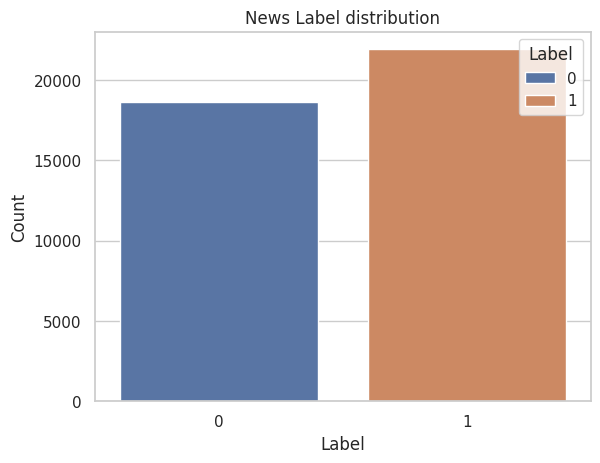

In [23]:
concat_df = pd.concat([train_df,test_df,eval_df])
category_counts = concat_df['label'].value_counts().reset_index()
category_counts.columns = ['Label', 'Count']

sns.set_theme(style="whitegrid")
sns.barplot(x='Label', y='Count', data=category_counts,hue = 'Label',legend=True)

plt.title("News Label distribution")
plt.xlabel("Label")
plt.ylabel("Count")

print(concat_df['label'].value_counts()/len(concat_df))

# Normalization des données, entrainer un tokenizer et visualisation 

### Question 2 :
À l'aide des deux liens ci-dessous, entraîner un tokenizer BPE sur l'ensemble de votre jeu de données.


Build a tokenizer from scratch = https://huggingface.co/docs/tokenizers/quicktour

Building a tokenizer, block by block = https://huggingface.co/learn/nlp-course/chapter6/8

In [9]:

# Function to generate training corpus from dataset
def get_training_corpus(dataset, column_name="content"):
    for i in range(0, len(dataset), 1000):
        yield dataset[column_name].iloc[i : i + 1000].astype(str).tolist()

# Initialize the tokenizer with a BPE model
tokenizer = None

# Set normalizers (optional: lowercase, NFD, etc.)
tokenizer.normalizer = normalizers.Sequence(None)

# Set pre-tokenizer
tokenizer.pre_tokenizer = None

# Define the BPE trainer with a vacab_size = 25_000
#[...]

# Train the tokenizer
#[...]


TypeError: argument 'normalizers': 'NoneType' object cannot be converted to 'PyList'

In [29]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers import normalizers
from tokenizers.pre_tokenizers import Whitespace


In [30]:
# Function to generate training corpus from dataset
def get_training_corpus(dataset, column_name="content"):
    for i in range(0, len(dataset), 1000):
        yield dataset[column_name].iloc[i : i + 1000].astype(str).tolist()

# Initialize the tokenizer with a BPE model
tokenizer = Tokenizer(BPE(unk_token="[UNK]"))

# Set normalizers (lowercase + unicode normalization + remove accents)
tokenizer.normalizer = normalizers.Sequence([
    normalizers.Lowercase(),
    normalizers.NFD(),
    normalizers.StripAccents()
])

# Set pre-tokenizer (split on whitespace)
tokenizer.pre_tokenizer = Whitespace()

# Define the BPE trainer with a vocab_size = 25_000
trainer = BpeTrainer(
    vocab_size=25_000,
    special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]
)

# Train the tokenizer
tokenizer.train_from_iterator(
    get_training_corpus(train_df, column_name="content"),
    trainer=trainer
)


In [ ]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers import normalizers
from tokenizers.pre_tokenizers import Whitespace

# Function to generate training corpus from dataset
def get_training_corpus(dataset, column_name="content"):
    for i in range(0, len(dataset), 1000):
        yield dataset[column_name].iloc[i : i + 1000].astype(str).tolist()

# Initialize the tokenizer with a BPE model
tokenizer = Tokenizer(BPE(unk_token="[UNK]"))

# Set normalizers (lowercase + unicode normalization + remove accents)
tokenizer.normalizer = normalizers.Sequence([
    normalizers.Lowercase(),
    normalizers.NFD(),
    normalizers.StripAccents()
])

# Set pre-tokenizer (split on whitespace)
tokenizer.pre_tokenizer = Whitespace()

# Define the BPE trainer with a vocab_size = 25_000
trainer = BpeTrainer(
    vocab_size=25_000,
    special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]
)

# Train the tokenizer
tokenizer.train_from_iterator(
    get_training_corpus(train_df, column_name="content"),
    trainer=trainer
)


In [ ]:
# Fonction pour générer le corpus d'entraînement à partir du dataset
def get_training_corpus(dataset, column_name="content"):
    for i in range(0, len(dataset), 1000):
        yield dataset[column_name].iloc[i:i + 1000].astype(str).tolist()

In [ ]:
# Initialisation du tokenizer avec un modèle BPE
tokenizer = Tokenizer(BPE(unk_token="[UNK]"))


In [ ]:
# Normalisation : mise en minuscules + suppression des accents
tokenizer.normalizer = Sequence([
    Lowercase(),
    NFD(),
    StripAccents()
])


In [ ]:
# Découpage du texte sur les espaces
tokenizer.pre_tokenizer = Whitespace()


In [ ]:
os.makedirs("../data/tokenizers",exist_ok=True)
#Save the tokenizer
tokenizer.save("../data/tokenizers/tokenizer.json")

In [ ]:

#load the tokenizer
tokenizer = Tokenizer.from_file("../data/tokenizers/tokenizer.json")

### Question 3 : 
Expliquer les sorties de "tokenizer.encode(txt)", ajouter une nouvelle colonne aux datasets avec la liste des "ids" pour chaque "content". 

In [ ]:
#Sample 1 original content
sample_text = train_df.sample().content.values[0]

# Encode the sample text using the tokenizer
#[...]

# Print results in a structured way
print("Original Text:")
#[...]

print("\nTokenized Output (Tokens):")
#[...]

print("\nTokenized Output (IDs):")
#[...]

print("\nNumber of Tokens:")
#[...]

print("\nDecoded Text:")
#[...]

### question 4 :
Proposer une visualisation sous forme de nuage de mots pour les faux  et les vrais articles. Vous pourrez exclure les mots de liaisons et la ponctuation ("a", "the", "," ...) qui n'apportent pas d'information en utilisant la bibliothèque "nlk" et sa base de "stop_word" en anglais. 

In [ ]:

concat_df = pd.concat([train_df,eval_df],axis=0)
concat_df["tokens"] = concat_df["content"].apply(lambda txt : tokenizer.encode(txt).tokens)
concat_df["ids"]= concat_df["content"].apply(lambda txt : tokenizer.encode(txt).ids) 

# Step 1: Extract Vocabulary
vocab = tokenizer.get_vocab()  # Returns a dictionary {word: token_id}
id_to_word = {id: word for word, id in vocab.items()}  # Reverse mapping


# Step 2: Count Word Frequencies
# Flatten the list of token IDs
all_ids  = [id for ids in concat_df["ids"] for id in ids]
all_ids_fake = [id for ids in concat_df[concat_df["label"] == 0]["ids"] for id in ids]
all_ids_true = None #[...]

# Count the frequency of each token ID
id_counts = Counter(all_ids)
id_counts_fake = None
id_counts_true = None

# Step 3: Map Token IDs to Words
# Convert token frequencies to word frequencies
word_frequencies = {id_to_word[id]: count for id, count in id_counts.items() if id in id_to_word}
word_frequencies_fake = None
word_frequencies_true = None


In [ ]:
nltk.download('stopwords')

ponctuation_set = {'(', ')', ',', '-', '.', ':', '’', '“'}
# Get the English stop word list and add your ponctuation stop word set
stop_words = set(stopwords.words('english')).union(ponctuation_set)

# Stop word filtration 
# #[...]

In [ ]:
# Step 4: Generate Word Cloud
#link : https://www.kaggle.com/code/niteshhalai/wordcloud-colormap

# Create the WordCloud object
#[...]
#[...]
#[...]

#### Question 5 :  
En utilisant la bibliothèque Gesim entrainer un model Word2Vec avec votre jeu de données et votre tokenizer. Explorer ensuite les représentations vectorielles renvoyées par le model sur quelques exemples ("trump", "said", "president", "people", ...)

link1 : https://medium.com/@manansuri/a-dummys-guide-to-word2vec-456444f3c673

link2 : https://radimrehurek.com/gensim/models/word2vec.html

link3 : https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial


In [ ]:

class MyIter:

    def __init__(self,sentences,tokenizer):
        self.sentences = sentences
        self.tokenizer = tokenizer

    def __iter__(self):

        for sentence in self.sentences:
            yield list(tokenizer.encode(sentence).tokens)


concat_df = pd.concat([train_df,eval_df],axis=0)

sentences_iterator = MyIter(sentences = concat_df["content"].to_list(),tokenizer=tokenizer)

In [ ]:
w2v_model = None

w2v_model.build_vocab(sentences_iterator)  # prepare the model vocabulary

for epoch in tqdm.tqdm(range(5)):
    #[...]
    pass
    
   


In [ ]:
os.makedirs("../models_checkpoints/tp1",exist_ok=True)
#save the model Word2Vec 
w2v_model.save("../models_checkpoints/tp1/fakenews_word2vec.model")

In [ ]:
w2v_model = Word2Vec.load("../models_checkpoints/tp1/fakenews_word2vec.model")

#### Exploration des embeddings 

In [ ]:
w2v_model.wv.most_similar(positive=["trump"])

In [ ]:
w2v_model.wv.most_similar(positive=["president"])

In [ ]:
w2v_model.wv.most_similar(positive=["said"])

# Entrainer un modèle de classification avec des poids aléatoires 

### Question 6 : 

* Construire des datasets train, eval et test avec la classe Dataset. 

link1 : https://plainenglish.io/blog/understanding-collate-fn-in-pytorch-f9d1742647d3

link2 : http://www.idris.fr/jean-zay/gpu/jean-zay-gpu-torch-data-preprocessing.html

* Ajout d'une colonne "input_ids" avec la méthode map

link : https://medium.com/@sujathamudadla1213/what-are-some-benefits-of-using-the-dataset-map-7dab03afb6d3

* Ajouter un index de padding pour les positions a ignorer par le modèle où encore pour compléter dans chaque batch pour obtenir une matrice

* Construire des dataloaders associés qui rajoutent le padding pour chaque batch.


In [ ]:
#transforme a pandas df to a torch dataset object 
#[...]
#[...]
#[...]

In [ ]:

# Define a function for tokenization
def tokenize_function(example):
    tokens = tokenizer.encode(example["content"]).ids
    return {"input_ids": tokens}
#[...]
#[...]
#[...]


In [ ]:
# Creation d'un index de padding pour les positions a ignorer par le modèle où encore pour compléter dans chaque batch pour obtenir une matrice
pad_idx = None

print("L'index de padding est :", pad_idx)

In [ ]:
# Define the custom collate function
def collate_fn(batch):
    """
    Custom collate function for padding.
    """
    pass

In [ ]:

# Create a DataLoader
batch_size = 64

train_dataloader = DataLoader(
 #[...]
 # #[...]
 # #[...]
 # #[...]   
)


eval_dataloader = DataLoader(
   
)


test_dataloader = DataLoader(
    #[...]
    #[...]
    #[...]
)


In [ ]:
# Example usage
for batch in train_dataloader:
    print(batch["input_ids"])
    print(batch["input_ids"].shape)  # Shape of the input_ids tensor
    print(batch["labels"])
    print(batch["labels"].shape)  # Shape of the labels tensor
    break

### Question 7 :

Developper une architecture de modèle héritant de la classe "nn.Module" qui converti les "input_ids" en embeddings, les moyennes pour donner une représentation vectorielle à chaque article. Le modèle doit renvoyer une prédiction entre deux classes :

link1 : https://medium.com/@spandey8312/text-classification-using-custom-data-and-pytorch-d88ba1087045

Remarque : vous pourrez utiliser le model Word2Vec précédemment entrainé pour initialiser la table d'embeddings du classifier  


##### Architecture 1

In [ ]:
class TextClassifierMean(nn.Module):

    def __init__(self, vocab_size, embedding_dim, embedding_model, num_classes, dropout=0.1):
        super().__init__()
        pass
        

    
    def forward(self, x):
        pass

##### Architecture 2

In [ ]:
class TextClassifierNormL2(nn.Module):

    def __init__(self, vocab_size, embedding_dim, embedding_model, num_classes, dropout=0.1):
        super().__init__()
        pass
    
    
    def forward(self, x):
        pass

## initialisation des modèles :

In [ ]:
# Training parameters
vocab_size = tokenizer.get_vocab_size()
embedding_dim = 100
num_classes = 2


In [ ]:
model_classifier_1 = TextClassifierMean(vocab_size, embedding_dim,w2v_model, num_classes)

# exemple aléatoire de "inputs_ids"
inputs_ids_test = torch.randint(low=0,high=200,size=(3,14)) #batch_size, Idx_token 
print(inputs_ids_test)

with torch.no_grad():
    model_classifier_1.eval() #permet de ne pas prendre en compte le dropout
    output_model_test = model_classifier_1(inputs_ids_test)
    
    print(output_model_test)

In [ ]:

model_classifier_2 = TextClassifierNormL2(vocab_size, embedding_dim,w2v_model, num_classes)

# exemple aléatoire de "inputs_ids"
inputs_ids_test = torch.randint(low=0,high=200,size=(3,14)) 
print(inputs_ids_test)

with torch.no_grad():
    model_classifier_2.eval() #permet de ne pas prendre en compte le dropout
    output_model_test = model_classifier_2(inputs_ids_test)
    
    print(output_model_test)

### Vérifier que la table d'embeddings du model est bien synchronisée avec les embeddings du model Word2Vec

In [ ]:
vocab_items = list(tokenizer.get_vocab().items())
random_token, random_index = vocab_items[np.random.choice(len(vocab_items))]

print("Randomly selected token:", random_token)
print("Index of the token:", random_index)

try:
    word_vector = torch.tensor(w2v_model.wv[random_token])
    print( word_vector == model_classifier_1.embedding.weight.data[random_index])

except KeyError as e:
    print(e)




### Question 8 : 

Reprendre la fonction "train_test" dans "module_train_tp1.py" et entrainer les poids de votre modèle sur 15 epochs.

In [ ]:
import module_train_tp1 as trainer
importlib.reload(trainer)

In [ ]:
num_epochs = 15
learning_rate = 1e-3

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model_classifier_1.parameters(), lr=learning_rate)

In [ ]:
os.makedirs("../models_checkpoints/tp1",exist_ok=True)
os.makedirs("./logs/tp1",exist_ok=True)

time = datetime.now().strftime("%Y%m%d_%H%M")
model_class = "TextClassifierMean_"

model_name = model_class + time + ".checkpoint.pth"
checkpoint_path = os.path.join("../models_checkpoints/tp1",model_name)

log_dir = "logs/tp1/" + model_class + time


In [ ]:

list_train_loss, list_eval_loss ,list_train_accuracy, list_eval_accuracy ,list_train_f1, list_eval_f1 = trainer.train_test(
    
)

In [ ]:
trainer.plot_metrics(list_train_loss, list_eval_loss, "cross entropie loss")
trainer.plot_metrics(list_train_accuracy, list_eval_accuracy , "accuracy")
trainer.plot_metrics(list_train_f1, list_eval_f1, "f1_score")


### Question 9 :
Evaluer le model sur les données test et exhiber des exemples d'articles prédit avec un mauvais label. 


In [ ]:
#Chargement des modèles entrainés

#model_name = "TextClassifierMean_20250130_1631.checkpoint.pth"
checkpoint_path = os.path.join("../models_checkpoints/tp1",model_name)

w2v_model = Word2Vec.load("../models_checkpoints/tp1/fakenews_word2vec.model")


model= TextClassifierMean(vocab_size, embedding_dim,w2v_model, num_classes)
model.load_state_dict(torch.load(checkpoint_path,weights_only=False))
model.to(device)

#### Evaluation du model sur le jeu de données test 

In [ ]:
# Evaluation du modèle de classification sur les données test
model.eval()
total_test_loss = 0.0
total_test_samples = 0

correct_predictions_test = 0

predict_labels_test_list = []
targets_test_list = []

with torch.no_grad():
    for batch in test_dataloader:

        pass

loss_test = None


accuracy_test = None
precision_test = None
recall_test = None
f1_score_test =  None


In [ ]:
# Print the metrics in a clear format
print(f"Test Metrics:")
print(f"Loss: {loss_test:.4f}")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1 Score: {f1_score_test:.4f}")

#### Visualisation des mauvaises predictions 

In [ ]:

def prediction_for_row(row,tokenizer,model):
    predicted_label = None
    return predicted_label

# Partial function to pass fixed arguments



# Map the prediction function to each row


# Optionally convert back to a pandas DataFrame if needed


In [ ]:
error_prediction_df = None
good_prediction_df = None

display_random_sample(error_prediction_df[['title', 'text', 'label','predict_label']],1) 
display_random_sample(good_prediction_df[['title', 'text', 'label','predict_label']],1) 


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

##link : https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

# Generate the confusion matrix
y_true = None
y_pred = None
confu_mat = None

# Define group names
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']

# Compute counts for each group
group_counts = ["{0:0.0f}".format(value) for value in confu_mat.flatten()]

# Compute percentages for each group
group_percentages = ["{0:.2%}".format(value) for value in confu_mat.flatten() / np.sum(confu_mat)]

# Combine names, counts, and percentages into a single label
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]

# Reshape labels to match the confusion matrix shape
labels = np.asarray(labels).reshape(confu_mat.shape)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confu_mat, annot=labels, fmt='', cmap='Blues')
plt.title('Confusion Matrix with Annotations')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


Proposer votre des exemples d'articles aliant fake-news et vrais articles et observez comment votre modèle généralise son apprentissage. 

In [ ]:
#link = https://library-nd.libguides.com/fakenews/examples

content_fake = """
Hey Facebook, As some of you may know, I'm Bill Gates. If you click that share link, I will give you $5,000. 
I always deliver, I mean, I brought you Windows XP, right?
"""

row = {
    "content" : content_fake}

label = None

print(label)

In [ ]:
content_fake = """
On 15 May 2014, the National Report published an article reporting that Barack Obama had (in defiance of constitutional provisions) shockingly proclaimed he would be seeking a third term as President of the United States:

President Barack Obama shocked the country this morning with news that he is running for a third term

"I can't abandon the American people now when they need me more than ever," Obama told reporters at a press conference this morning. "We've come this far as a nation, now is not the time to do something different. This is the change you wanted and this is the change you’re getting." 

"""

row = {
    "content" : content_fake}

label = None

print(label)

In [ ]:
#link = https://www.bbc.com/news/articles/cq5eewvy3nlo

content_true= """
Donald Trump was rushed to safety on Sunday after what the FBI termed an apparent assassination attempt at his golf course in West Palm Beach, Florida.

Ryan Wesley Routh, 58, was arrested and charged with firearms offences.

The incident comes almost exactly two months after a shooting at a Trump rally in Butler, Pennsylvania, which left the Republican nominee with minor injuries and killed a man in the crowd.

Here is what we know so far about Sunday.
How was the suspect spotted?

The incident unfolded at the Trump International Golf Club in West Palm Beach, about 15 minutes from Trump's Florida residence, Mar-a-Lago.

A gunman was first seen by Secret Service agents, who were sweeping the course. Agents usually go one hole ahead to perform security checks, according to police.

The muzzle of a rifle - an SKS semi-automatic - was spotted sticking through the shrubbery that lines the course.

At the time, Trump was about 300-500 yards (275-460m) away from the spot.

An agent "immediately engaged" with the person holding the rifle, who fled, Sheriff Rik Bradshaw said. The suspect did not fire his weapon during the incident.

On 16 September, acting Secret Service director Ron Rowe said Trump was "across the course and out of sight of the sixth green" when the Secret Service agent opened fire.

At no point is the suspect believed to have had a clear line of sight to the former president.

Records show that Routh's phone had been in the area for about 12 hours, from around 02:00 to 13:31 local time, according to court documents and police officials. 

"""

row = {
    "content" : content_true}

label = None

print(label)

In [ ]:
#link = https://www.bbc.com/news/articles/cr56gr6p49eo

content_true="""Russia claims that its forces have captured the front-line town of Kurakhove in eastern Ukraine's Donetsk region.

The town has borne the brunt of Russian advances in recent months and is a stepping-stone to the key logistical hub of Pokrovsk.

Ukraine has not acknowledged the fall of Kurakhove, which is 35km (21 miles) south of Pokrovsk.

Fierce fighting has also been under way in Russia's Kursk region in recent days after Ukraine launched a counter-attack on Sunday.

An image taken from social media and supplied by the Reuters news agency appears to show a soldier holding up a Russian flag in Kurakhove. The image has not been verified by the BBC.

Viktor Trehubov, spokesperson for Ukraine's Khortytsia group of forces, told Reuters news agency that, as of Monday morning, Ukrainian forces were still engaging Russian troops inside Kurakhove.

Kurakhove is linked to Pokrovsk by roads that are part of the infrastructure to move troops and supplies along the front line.

The taking of Kurakhove would allow the Russians to go north to attack Pokrovsk from a new direction, analyst Roman Pohorily said.

Russia's defence ministry also claimed on Monday that the village of Dachenske, which about 8km south of Pokrovsk, had been captured by its forces.

Kyiv's forces are reportedly suffering from manpower shortages and have been losing ground in the east of Ukraine in recent months, as Russian troops advance.

"""

row = {
    "content" : content_true}

label = None

print(label)